In [1]:
import numpy as np
from scipy.stats import lognorm, uniform
import matplotlib.pyplot as plt
from scipy import integrate

ctr_boost = np.array([1, 1.1, 1.2, 1.3])
cvr_boost = np.array([1, 1.1, 1.2, 1.3])
voucher = np.array([0, 2, 4, 8])
ctrs = np.random.uniform(0.005, 0.5, (50, 8))
cvrs = np.random.uniform(0.005, 0.5, (50, 8))
valuations = np.random.uniform(5, 50, (50, 8))

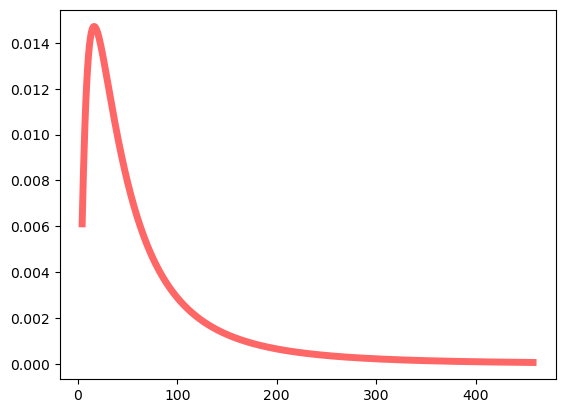

In [17]:
x = np.linspace(lognorm.ppf(0.01, s = 1, scale=np.exp(3.8)), lognorm.ppf(0.99, s = 1, scale = np.exp(3.8)), 1000).reshape(-1, 1)
def virtual_value(v):
    return v - ((1 - lognorm.cdf(v, s = 1, scale = np.exp(3))) / lognorm.pdf(v, s = 1, scale = np.exp(3)))
y = lognorm.pdf(x, s = 1, scale=np.exp(3.8))
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, 'r-', lw = 5, alpha = 0.6)

In [19]:
v = lognorm.rvs(size=(10000, 1), s = 1, scale = np.exp(3.8))
t = np.mean(v)

mu = np.log(t) - 0.5
print(mu)

3.7883376817072776


In [11]:
def find_index(value_list, k):
    l, r = 0, len(value_list) - 1
    while(l < r):
        mid = (l + r + 1) // 2
        if value_list[mid] > k:
            r = mid - 1
        else:
            l = mid
    return l

In [4]:
virtual_value_list = virtual_value(x)

In [22]:
def allocation_rule(ctr, cvr):
    allocations = []
    generalized_virtual = []

    best_voucher_arg = np.argmax(ctr_boost * ctr * virtual_value(x) - cvr_boost * cvr * voucher, axis = -1)
    generalized_virtual = np.max(ctr_boost * ctr * virtual_value(x) - cvr_boost * cvr * voucher, axis = -1)
    flag = generalized_virtual > 0
    allocations = ctr * ctr_boost[best_voucher_arg]
    allocations = allocations * flag
    # for i in x:
    #     best_voucher_arg = np.argmax(ctr_boost * ctr * virtual_value(x) - cvr_boost * cvr * voucher, axis = -1)
    #     best_voucher = voucher[best_voucher_arg]
    #     generalized_virtual.append(np.max(ctr * ctr_boost * (virtual_value(i) - cvr_boost * cvr * voucher)))
    #     if virtual_value(i) < 0:
    #         allocations.append(0)
    #     else:
    #         allocations.append(ctr * ctr_boost[best_voucher_arg])
    return allocations

def simulate_an_auction(n):
   '''
      n bidders
   '''
   ctrs = np.random.uniform(0.005, 0.5, (n, 1))
   cvrs = np.random.uniform(0.005, 0.5, (n, 1))
   valuations = lognorm.rvs(s=1, scale=np.exp(3), size=(n, 1))
   best_voucher_arg = np.argmax(ctr_boost * ctrs * (virtual_value(valuations) - cvr_boost * cvrs), axis = -1)
   rank_score = np.max(ctr_boost * ctrs * (virtual_value(valuations) - cvr_boost * cvrs), axis = -1)
   re_rank = np.argsort(rank_score, axis = -1)
   highest_idx = re_rank[-1]
   second_highest = re_rank[-2]
   if rank_score[re_rank[-1]] < 0:
      return 0, -1, 0
   target = rank_score[second_highest] if rank_score[second_highest] > 0 else 0

   allocations = allocation_rule(ctrs[highest_idx], cvrs[highest_idx])
   virtual_value_list = np.max(ctr_boost * ctrs[highest_idx] * (virtual_value(x) - cvr_boost * cvrs[highest_idx]),axis = -1)
   start = find_index(virtual_value_list, target)
   end = find_index(x, valuations[highest_idx])
   payment = x[end, 0] * allocations[end] - integrate.trapz(x[start:end, 0], allocations[start:end])

   # for i in range(n):
   #    allocations_all.append(allocation_rule(ctrs[i], cvrs[i]))
   #    best_voucher_arg = np.argmax(ctrs[i] * ctr_boost * (virtual_value(valuations[i]) - cvr_boost * cvrs[i] * voucher))
   #    best_vouchers[i] = best_voucher_arg
   #    rank_score[i] = np.max(ctrs[i] * ctr_boost * (virtual_value(valuations[i]) - cvr_boost * cvrs[i] * voucher))
   # re_rank = np.argsort(rank_score)
   # highest_idx = re_rank[-1]
   # second_highest_rank_score = rank_score[re_rank[-2]]
   # if second_highest_rank_score < 0:
   #     second_highest_rank_score = 0
   # target = second_highest_rank_score / (ctrs[highest_idx] * ctr_boost[best_vouchers[highest_idx]]) + (cvr_boost[best_vouchers[highest_idx]] * cvrs[highest_idx] * voucher[best_vouchers[highest_idx]])
   # if rank_score[re_rank[-1]] < 0:
   #    return 0, -1, 0
   # 计算payment
   # start = find_index(virtual_value_list, target)
   # end = find_index(x, valuations[highest_idx])
   
   # payment = x[end] * allocations[highest_idx][end] - integrate.trapz(x[start:end], allocations[highest_idx][start:end])
   return payment, highest_idx, ctrs[highest_idx, 0] * ctr_boost[best_voucher_arg[highest_idx]] * cvr_boost[best_voucher_arg[highest_idx]] * cvrs[highest_idx, 0] * voucher[best_voucher_arg[highest_idx]]

In [11]:
from tqdm.notebook import tqdm
revenues, costs = [], []
for i in tqdm(range(200)):
    revenue, _, cost = simulate_an_auction(8)
    revenues.append(revenue)
    costs.append(cost)

print(np.mean(revenues))
print(np.mean(costs))

  0%|          | 0/200 [00:00<?, ?it/s]

In [6]:
n = 8
ctrs = np.random.uniform(0.005, 0.5, (n, 1))
cvrs = np.random.uniform(0.005, 0.5, (n, 1))
valuations = lognorm.rvs(s=1, scale=np.exp(3), size=(n, 1))

In [7]:
cvr_boost * ctrs * (virtual_value(valuations) - cvr_boost * cvrs)

array([[11.81071677, 12.98995202, 14.16885338, 15.34742083],
       [ 4.32052084,  4.75232256,  5.18407875,  5.61578941],
       [-3.33988475, -3.68208395, -4.02577599, -4.3709609 ],
       [-0.54670387, -0.60416735, -0.66213867, -0.72061782],
       [ 1.72486129,  1.8886155 ,  2.05078209,  2.21136106],
       [-2.38009222, -2.61827008, -2.85647859, -3.09471775],
       [-3.92646005, -4.32942665, -4.73426971, -5.14098924],
       [-1.41838006, -1.56892522, -1.72105351, -1.87476492]])

In [25]:
from tqdm.notebook import tqdm
revenues, costs = [], []
for i in tqdm(range(100000)):
    revenue, _, cost = simulate_an_auction(8)
    revenues.append(revenue)
    costs.append(cost)

print(np.mean(revenues))
print(np.mean(costs))

  0%|          | 0/100000 [00:00<?, ?it/s]

30.644047335447162
1.0164969146008966
